In [1]:
from matplotlib import pyplot as plt
import platform, os, sys, h5py, re
import numpy as np
from tabulate import tabulate
from pprint import pprint
from tqdm import tqdm

if 'Windows' in platform.system():
    sys.path.append(r'C:\Users\Gerwin\Documents\Code')
    from BEMHelper import interpolate_slow
else:
    sys.path.append('/mnt/s/_Data/160603 - EonHe M016v5/modules')
    sys.path.append("/Users/gkoolstra/Documents/Code")
    from BEMHelper import interpolate_slow
    %config InlineBackend.figure_format='retina'

from Common import common, kfit
from TrapAnalysis import trap_analysis, import_data, artificial_anneal as anneal
from HeliumSurface.static_surface import *
# from ipywidgets import interact

%matplotlib inline
from ipywidgets import interactive
import matplotlib.pyplot as plt
import numpy as np

# Greater trap area simulation

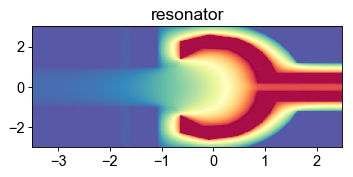

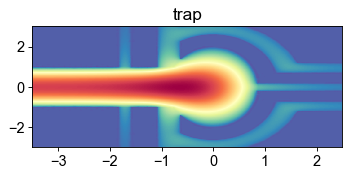

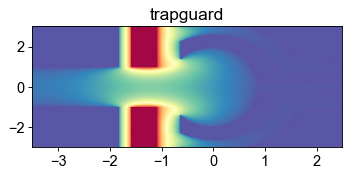

In [21]:
if 'Windows' in platform.system():
    datafolder = r"S:\_Data\190321 - EonHe Sweet Spot Simulations\Trap simulation results"
else:
    datafolder = r"/Volumes/slab/Gerwin/Electron on helium/Maxwell/M018 Yggdrasil/M018V6/With L3 etch"

# Evaluate all files in the range
yeval = anneal.construct_symmetric_y(-3, 201)
xeval = np.linspace(-3.5, 2.5, 1001)

prefix = "000_M019V2"
datafiles = [prefix + x for x in ["_Res1V.dsp", "_Trap1V.dsp", "_TrapGuard1V.dsp"]]
output = list()
names = ['resonator', 'trap', 'trapguard']

for name, datafile in zip(names, datafiles):
    plt.figure(figsize=(14.,4.))
    common.configure_axes(13)
    elements, nodes, elem_solution, bounding_box = trap_analysis.load_dsp(os.path.join(datafolder, datafile))
    xdata, ydata, Udata = interpolate_slow.prepare_for_interpolation(elements, 
                                                                     nodes, 
                                                                     elem_solution)
    xcenter = np.mean(bounding_box[0:2])
    ycenter = np.mean(bounding_box[2:4])
#     xdata -= xcenter
#     ydata -= ycenter

#     print(xcenter, ycenter)

    plt.figure(figsize=(7.,4.))
    xdata, ydata, Udata = interpolate_slow.prepare_for_interpolation(elements, nodes, elem_solution)
    xinterp, yinterp, Uinterp = interpolate_slow.evaluate_on_grid(xdata, ydata, Udata, 
                                                                  xeval=xeval, 
                                                                  yeval=yeval, 
                                                                  clim=(0, 1), 
                                                                  plot_mesh=False, 
                                                                  plot_data=False,
                                                                  plot_axes='xy', 
                                                                  cmap=plt.cm.viridis)

    # Mirror around the y-axis
    ysize, xsize = np.shape(Uinterp)
    Uinterp_symmetric = np.zeros((2 * ysize, xsize))
    Uinterp_symmetric[:ysize, :] = Uinterp
    Uinterp_symmetric[ysize:, :] = Uinterp[::-1, :]

    y_symmetric = np.zeros((2 * ysize, xsize))
    y_symmetric[:ysize, :] = yinterp
    y_symmetric[ysize:, :] = -yinterp[::-1, :]

    x_symmetric = np.zeros((2 * ysize, xsize))
    x_symmetric[:ysize, :] = xinterp
    x_symmetric[ysize:, :] = xinterp
    
    output.append({'name' : name, 
                   'V' : np.array(Uinterp_symmetric, dtype=np.float64),
                   'x' : np.array(x_symmetric, dtype=np.float64), 
                   'y' : np.array(y_symmetric, dtype=np.float64)})
    
for k in range(3):
    plt.figure(figsize=(5.,2.))
    plt.pcolormesh(output[k]['x'], output[k]['y'], output[k]['V'], cmap=plt.cm.Spectral_r)
#     anneal.draw_from_dxf(os.path.join(datafolder, prefix + ".dxf"), lw=1, color='k')
    plt.title(output[k]["name"])
    plt.xlim(np.min(output[k]['x']), np.max(output[k]['x']))
    plt.ylim(np.min(output[k]['y']), np.max(output[k]['y']))

In [22]:
t = trap_analysis.TrapSolver()
#x, y, cropped_potentials = t.crop_potentials(output, ydomain=None, xdomain=None)

if len(np.shape(output[0]['x'])) == 3:
    x = output[0]['x'][:, :, h_idx]
    y = output[0]['y'][:, :, h_idx]
else:
    x = output[0]['x']
    y = output[0]['y']
    
import matplotlib as mpl
# common.configure_axes(13)
mpl.rcParams['figure.figsize'] = (8.,3.)
# fig = plt.figure(figsize=(8.,6.))

def plot_combined_potential(resonator=+0.00, trap=+0.25, trapguard=-0.0, scaling=0.0, 
                            color_minimum=-0.10, color_maximum=0.10, chemical_potential=-0.260, 
                            trap_resg_locked=False, left_right_guard_locked=False, 
                            auto_scale=False):
    
    plt.figure(1)
    
    if trap_resg_locked:
        resonatorguard = 1/0.25*(trap - 0.30)
    if left_right_guard_locked:
        resonatorguard = trapguard
    coefficients = np.array([resonator, trap, trapguard]) * 10**scaling
    
    for k, coeff in enumerate(coefficients):
        if k == 0: 
            if len(np.shape(output[0]['x'])) == 3:
                combined_potential = coeff * output[k]['V'][:, :, h_idx]
            else:
                combined_potential = coeff * output[k]['V']
        else:
            if len(np.shape(output[0]['x'])) == 3:
                combined_potential += coeff * output[k]['V'][:, :, h_idx]
            else:
                combined_potential += coeff * output[k]['V']
                
    TS = anneal.TrapAreaSolver(x[0,:], y[:,0], -combined_potential.T, smoothing=0.01)
    
    centeridx = int(np.shape(y)[0]/2)
    plt.plot(x[0, :], TS.V(x[0,:], 0))#, color='darkorange')
#     plt.hlines(chemical_potential, np.min(x[0,:]), np.max(x[0,:]), linestyles='--')
        
    ymin, ymax = np.min(-combined_potential[centeridx,:]), np.max(-combined_potential[centeridx,:])
    
    print(x[0, np.argmin(-combined_potential[centeridx,:int(np.shape(combined_potential)[1]/2)])])
    plt.ylabel("Energy (eV)")
    plt.xlim(np.min(x), np.max(x))
    if not auto_scale:
        plt.ylim(color_minimum, color_maximum)
#     else:
#         color_minimum, color_maximum = plt.ylim()
        #plt.ylim(-0.7, -0.65)
        
    biasVoltages = "$V_{res}$ = %.4f\n$V_{trap}$ = %.4f\n$V_{tguard}$ = %.4f\n" % \
    (resonator * 10**scaling, trap * 10**scaling, trapguard * 10**scaling)
    
    plt.xlabel("x (%sm)"%(chr(956)))
    plt.show()

    
    
interactive_plot = interactive(plot_combined_potential, resonator=(-5.0, 5.0, 0.05), trap=(-5, 5, 0.05), 
                             trapguard=(-5, 5, 0.05), scaling=(-2.0, 1.0, 0.01),
                             chemical_potential=(-5, 5, 0.05), color_minimum=(-5, 5, 0.05), color_maximum=(-5, 5, 0.05), 
                             trap_resg_locked=False, left_right_guard_locked=False, auto_scale=True);

# output = interactive_plot.children[-1]
# output.layout.height = '350px'
interactive_plot

In [31]:
%matplotlib inline

import matplotlib as mpl
x = output[0]['x']
y = output[0]['y']

common.configure_axes(13)
mpl.rcParams['figure.figsize'] = (8., 4.)
#plt.figure(figsize=(7.,4.))

def plot_combined_potential(resonator=+0.0, trap=0.20, trapguard=-0.20, scaling=0.0, 
                            color_minimum=-1, color_maximum=1, fit_x = 0.0, 
                            resonator_trap_locked=False, left_right_guard_locked=False, fit_potential_minimum=True, 
                            auto_scale=True):
    
    fig = plt.figure()
    plt1 = fig.add_subplot(1,2,1)
    plt2 = fig.add_subplot(1,2,2)
    
    if resonator_trap_locked:
        trap = resonator
    if left_right_guard_locked:
        resonatorguard = trapguard
    coefficients = np.array([resonator, trap, trapguard]) * 10**scaling
    
    for k, coeff in enumerate(coefficients):
        if k == 0: 
            combined_potential = coeff * output[k]['V'][:, :]
        else:
            combined_potential += coeff * output[k]['V'][:, :]  
    
    if not auto_scale:
        plt1.pcolormesh(x, y, combined_potential, cmap=plt.cm.Spectral_r, 
                        vmin=color_minimum, vmax=color_maximum)
    else:
        plt1.pcolormesh(x, y, combined_potential, cmap=plt.cm.Spectral_r)
    
    if fit_potential_minimum:
        trap_xmin, trap_xmax = (-1.5, 1.5)
        trap_ymin, trap_ymax = (-3.0, 3.0)
        trap_xmin_idx, trap_xmax_idx = common.find_nearest(x[0,:], trap_xmin), common.find_nearest(x[0,:], trap_xmax)
        trap_ymin_idx, trap_ymax_idx = common.find_nearest(y[:,0], trap_ymin), common.find_nearest(y[:,0], trap_ymax)
                
        yidx, xidx = np.where(combined_potential[trap_ymin_idx:trap_ymax_idx, trap_xmin_idx:trap_xmax_idx]\
                              ==np.max(combined_potential[trap_ymin_idx:trap_ymax_idx, trap_xmin_idx:trap_xmax_idx]))
        yidx, xidx = yidx[1]+trap_ymin_idx, xidx[1]+trap_xmin_idx
    else: 
        yidx = np.array([common.find_nearest(y[:,0], 0.0)])
        xidx = common.find_nearest(x[0,:], fit_x)
    
    plt1.plot([x[-1,xidx],x[0,xidx]], [y[-1,xidx], y[0,xidx]], '--', color='white')
    plt1.set_xlim(np.min(x), np.max(x))
    plt1.set_ylim(np.min(y), np.max(y))
    
    plt1.set_xlabel("x (%sm)"%(chr(956)))
    plt1.set_ylabel("y (%sm)"%(chr(956)))
    
    Vdata = combined_potential[:,xidx]
    xdata = y[:,xidx]
    xfit = np.linspace(-0.25, 0.25, 1E2)
    plt2.plot(xdata, Vdata, '.k')    
    
    fr, ferr = t.fit_electron_potential(xdata, Vdata, fitdomain=(-0.25, +0.25), do_plot=True)
    f0, sigmaf0 = t.get_electron_frequency(fr, ferr, verbose=False)
    
    fr, ferr = kfit.fit_poly(xdata, Vdata, fitparams=[0, 1], mode='even', domain=(-0.25, +0.25), verbose=False)
    plt2.plot(xfit, kfit.polyfunc_even(xfit, *fr), '-r', lw=1.0, label="$f_0$ = %.3f +/- %.3f GHz"%(f0/1E9, sigmaf0/1E9))
    plt.legend(loc=2, frameon=False, prop={"size" : 10})

    plt2.set_xlabel("x (%sm)"%(chr(956)))
    plt2.set_ylabel("Potential (V)")
#     plt2.set_ylim(color_minimum, color_maximum)
    
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()
    
    biasVoltages = "$V_{res}$ = %.3f\n$V_{trap}$ = %.3f\n$V_{tguard}$ = %.3f\n" % \
    (resonator * 10**scaling, trap * 10**scaling, trapguard * 10**scaling)
    
    fig.tight_layout()
    print(biasVoltages)
    plt.show()
    
interactive_plot = interactive(plot_combined_potential, resonator=(-5.0, 5.0, 0.01), trap=(-5, 5, 0.05), 
                               trapguard=(-5, 5, 0.05), scaling=(-2.0, 1.0, 0.01),
                               color_minimum=(-5, 5, 0.001), color_maximum=(-5, 5, 0.001), fit_x = (-1, 6, 0.05), 
                               resonator_trap_locked=False, left_right_guard_locked=False, 
                               fit_potential_minimum=False, auto_scale=True);

interactive_plot

In [24]:
def Vtrap_expt(Vrg, mu):
    f_mu = -1.755-7*mu
    print(f_mu)
    return (f_mu-0.120) - 1.15*Vrg

def Vtrap_th_expt(Vrg, mu):
    return (-0.120 - 1.69 * mu)*np.ones(len(Vrg))

def Vtrap_IsoBarrier_expt(Vrg, contour):
    return 0.32 + 10 * contour + 1.15 * Vrg

def Vrg_IsoBarrier_expt(Vtrap, contour):
    return 1/1.15 * (Vtrap - 0.32 - 10 * contour)

In [29]:
%matplotlib inline
from tqdm import tqdm
from scipy.constants import electron_mass as me, elementary_charge as qe

x = output[0]['x']
y = output[0]['y']

Vres = 0.05
Vtraps = np.arange(0.00, 0.2, 0.005)
Vtrapguards = np.arange(0.00, -0.2, -0.005)

mu = -0.270
fit_x = 0.0
fit_potential_minimum=1

efreqs_x = np.zeros((len(Vtraps), len(Vtrapguards)))
efreqs_y = np.zeros((len(Vtraps), len(Vtrapguards)))
xposition = np.zeros((len(Vtraps), len(Vtrapguards)))
barrier_height = np.zeros((len(Vtraps), len(Vtrapguards)))
barrier_height_minus_trap = np.zeros((len(Vtraps), len(Vtrapguards)))
barrier_minus_mu = np.zeros((len(Vtraps), len(Vtrapguards)))
trap_level = np.zeros((len(Vtraps), len(Vtrapguards)))
quartic_term = np.zeros((len(Vtraps), len(Vtrapguards)))
quadratic_term = np.zeros((len(Vtraps), len(Vtrapguards)))
quartic_term_x = np.zeros((len(Vtraps), len(Vtrapguards)))
quadratic_term_x = np.zeros((len(Vtraps), len(Vtrapguards)))

for n, trap in tqdm(enumerate(Vtraps)):
    for m, trapguard in enumerate(Vtrapguards):    
        coefficients = np.array([Vres, trap, trapguard])

        for k, coeff in enumerate(coefficients):
            if k == 0: 
                combined_potential = coeff * output[k]['V']
            else:
                combined_potential += coeff * output[k]['V']

        if fit_potential_minimum:
            trap_xmin, trap_xmax = (-1.5, 1.0)
            trap_ymin, trap_ymax = (-3.0, 3.0)
            trap_xmin_idx, trap_xmax_idx = common.find_nearest(x[0,:], trap_xmin), common.find_nearest(x[0,:], trap_xmax)
            trap_ymin_idx, trap_ymax_idx = common.find_nearest(y[:,0], trap_ymin), common.find_nearest(y[:,0], trap_ymax)

            yidx, xidx = np.where(combined_potential[trap_ymin_idx:trap_ymax_idx, trap_xmin_idx:trap_xmax_idx]\
                                  ==np.max(combined_potential[trap_ymin_idx:trap_ymax_idx, trap_xmin_idx:trap_xmax_idx]))
            yidx, xidx = yidx[1]+trap_ymin_idx, xidx[1]+trap_xmin_idx
        else: 
            yidx = np.array([common.find_nearest(y[:,0], 0.0)])
            xidx = common.find_nearest(x[0,:], fit_x)

        f0s = list()
        quartic_terms_y, quartic_terms_x  = list(), list()
        quadratic_terms_y, quadratic_terms_x = list(), list()
        # Average f0 one index around the fit_x or potential minimum.
        for X in np.arange(xidx-1, xidx+1 + 1, 1):
            # Determine the electron motional frequency in the y-direction (across-channel)
            Vdata = combined_potential[:,X]
            xdata = y[:,X]
            center = y[yidx, X]

#             fr, ferr = t.fit_electron_potential(xdata, Vdata, fitdomain=(-0.25, +0.25), do_plot=False)
#             f0, sigmaf0 = t.get_electron_frequency(fr, ferr, verbose=False)
#             f0s.append(f0)
            
            # V = a0 + a1 x^2 + a2 x^4
            fr, ferr = kfit.fit_poly(xdata, Vdata, fitparams=[0, 1, 2], mode='even', 
                                     domain=(-0.5, +0.5), verbose=False)
            a1, a2 = fr[1], fr[2]
            
            quartic_terms_y.append(a2)
            quadratic_terms_y.append(a1)
            
            # Then determine the electron motional frequency in the x-direction (along channel)
            # There is a double well, calculate the minimum according to the fit (take the positive solution)
            xdata = x[yidx, :]
            Vdata = combined_potential[yidx, :]
            center = x[yidx, X]
            
            # V = a0 + a1 (x - a2)^2
            try:
                fr, ferr = kfit.fit_parabola(xdata, Vdata, fitparams=[0, 1, center], verbose=False, 
                                             domain=(center-0.25, center+0.25))
#                 a1, a2 = fr[1], fr[2]
            except:
                a1, a2 = np.nan, np.nan

#             fr, ferr = kfit.fit_poly(xdata, Vdata, fitparams=[0, 1], mode='even', 
#                                      domain=(center-0.25, center+0.25), verbose=False)
            a1, a2 = fr[1], 0 #fr[2]
            
            quartic_terms_x.append(a2)
            quadratic_terms_x.append(a1)
            
#             quadratic_terms_x.append(a1)
        
        if np.mean(quartic_terms_y) < 0 and np.mean(quadratic_terms_y) > 0:
            # If there's a double well
            efreqs_y[n,m] = 1 / (2 * np.pi) * np.sqrt(-qe * -4 * np.mean(quadratic_terms_y) * 1E12 / me) 
            efreqs_x[n,m] = 1 / (2 * np.pi) * np.sqrt(-qe * 2 * np.mean(quadratic_terms_x) * 1E12 / me) 
        else:
            efreqs_y[n,m] = 1 / (2 * np.pi) * np.sqrt(-qe * 2 * np.mean(quadratic_terms_y) * 1E12 / me)
            efreqs_x[n,m] = 1 / (2 * np.pi) * np.sqrt(-qe * 2 * np.mean(quadratic_terms_x) * 1E12 / me)

#         plt.figure()
#         plt.plot(xdata, Vdata, '-k')
#         plt.plot(xdata, kfit.parabolafunc(xdata, *fr), '-r')
#         plt.ylim(np.min(Vdata), np.max(Vdata))
            
#         efreqs[n,m] = np.mean(f0s)
        
        res_barrier = (1.0, 2.0)
        res_barrier_min_idx = common.find_nearest(x[0,:], res_barrier[0])
        res_barrier_max_idx = common.find_nearest(x[0,:], res_barrier[1])
        trap_level_idx = common.find_nearest(x[0,:], -5.0)
        
        trap_barrier = (-2.5, -1.0)
        trap_barrier_min_idx = common.find_nearest(x[0,:], trap_barrier[0])
        trap_barrier_max_idx = common.find_nearest(x[0,:], trap_barrier[1])
        
        quartic_term[n, m] = np.mean(quartic_terms_y)
        quadratic_term[n, m] = np.mean(quadratic_terms_y)
        
        quartic_term_x[n, m] = np.mean(quartic_terms_x)
        quadratic_term_x[n, m] = np.mean(quadratic_terms_x)
        
        
        xposition[n,m] = x[0, xidx]
#         barrier_height[n,m] = np.max(-combined_potential[int(len(y[:,0])/2), barrier_min_idx:barrier_max_idx])
        barrier_height_minus_trap[n,m] = np.min([np.max(-combined_potential[int(len(y[:,0])/2), res_barrier_min_idx:res_barrier_max_idx]) \
                                         + combined_potential[yidx, xidx], 
                                                np.max(-combined_potential[int(len(y[:,0])/2), trap_barrier_min_idx:trap_barrier_max_idx]) \
                                         + combined_potential[yidx, xidx]])
        barrier_minus_mu[n,m] = np.max(-combined_potential[int(len(y[:,0])/2), res_barrier_min_idx:res_barrier_max_idx]) - mu
        trap_level[n,m] = -combined_potential[int(len(y[:,0])/2), trap_level_idx]

40it [00:22,  1.75it/s]


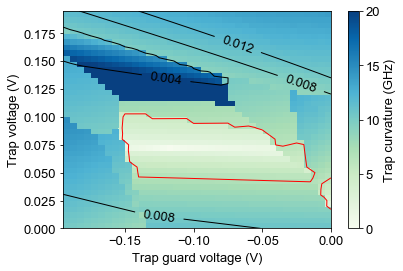

In [30]:
Em = ma.masked_where(barrier_minus_mu<0, efreqs_y/1E9)
Zm = ma.masked_where(barrier_minus_mu<0, barrier_height_minus_trap)
levels = np.arange(0, 0.016, 0.004).tolist() + np.arange(0.020, 0.050, 0.010).tolist()
fontsize = 13

fig=plt.figure(figsize=(6., 4.))
common.configure_axes(fontsize)
plt.pcolormesh(Vtrapguards, Vtraps, Em, cmap=plt.cm.GnBu, vmin=0, vmax=20)
cbar = plt.colorbar()
cbar.ax.set_ylabel("Trap curvature (GHz)")
cbar.set_ticks([0, 5, 10, 15, 20])
plt.xlim(np.min(Vtrapguards), np.max(Vtrapguards))
plt.ylim(np.min(Vtraps), np.max(Vtraps))
plt.xlabel("Trap guard voltage (V)")
plt.ylabel("Trap voltage (V)")

x = np.linspace(-0.6, 0.0, 100)
CS = plt.contour(Vtrapguards, Vtraps, Zm, colors='black', levels=levels, linewidths=1)
plt.clabel(CS, colors='black', inline=1, fontsize=fontsize)

# plt.contour(Vtrapguards, Vtraps, efreqs_x/1E9, colors='red', levels=[6.5], linewidths=1, alpha=0.5)
CS = plt.contour(Vtrapguards, Vtraps, Em, colors='red', levels=[6.5], linewidths=1)
# fig.tight_layout()